# Alternative Polyadenylation in scRNA-Seq

Alternative polyadenylation (APA) is a biological process that occurs during the maturation of messenger RNA (mRNA), where different polyadenylation signals are used within the same gene. This means a single DNA sequence can generate multiple versions of mRNA with different lengths at the 3’ end. These variations can affect RNA stability, cellular localization, and how the RNA is translated into protein. As a result, APA plays an important role in regulating gene expression and may be associated with processes such as cell differentiation and diseases like cancer.

The [SCAPE-APA](https://github.com/chengl7-lab/scape) (Single Cell Analysis of Polyadenylation Events) is a computational package developed to identify and quantify alternative polyadenylation events in scRNA-seq data. It allows researchers to study how different cells use distinct polyadenylation sites in their genes, revealing additional layers of regulation that are not captured by classical gene expression analysis.

In this notebook, we will use SCAPE-APA within the Google Colab environment to estimate alternative polyadenylation events from scRNA-seq data. The goal is to offer a practical and intuitive introduction to this type of analysis, demonstrating how APA contributes to regulatory diversity across individual cells.

In [ ]:
# Install python3-conda
# (!) signals that it is a command for the Linux terminal

!apt-get install -y python3-conda

Conda is a package for environment manager used primarily in data science and bioinformatics. It makes it easy to install software and libraries, even those with complex dependencies.

A Conda virtual environment is an isolated space where you can install specific versions of packages without interfering with other installations on your system. This avoids conflicts and ensures reproducibility of analyses.

In [ ]:
# Installing the condalab package, allowing you to use Conda in Google Colab, along with its packages and features.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
# Installation of numerical packages and tools for data visualization and management in the Conda environment.

# Creates the environment named scape_env with python version 3.11
!conda create -y -n scape_env python=3.11

#installs the necessary packages
!conda run -n scape_env conda install -y anaconda::numpy anaconda::scipy anaconda::pandas anaconda::matplotlib
!conda run -n scape_env conda install -y anaconda::click anaconda::tomli-w anaconda::requests
!conda run -n scape_env conda install -y conda-forge::psutil conda-forge::tomli-w
!conda run -n scape_env conda install -y bioconda::bedtools bioconda::pybedtools bioconda::pysam bioconda::gffutils
!conda run -n scape_env pip install taichi
!conda run -n scape_env pip install scape-apa

In [ ]:
# Verifying SCAPE-APA installation.

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && scape --help"

GitHub is an online platform where developers can store, share, and collaborate on code projects using the Git version control system.

The git clone command is used to copy an entire repository from GitHub (or another Git server) to your local repository. It downloads all of the files, version history, and project structure, allowing you to work locally. Let's do this like SCAPE-APA

In [ ]:
# Getting the files from the GitHub repository.
!git clone https://github.com/chengl7-lab/scape.git

# moving to the tutorial directory inside scape
%cd scape/tutorial

In [ ]:
#List of files inside the "toy example" folder.

!ls -lh /content/scape/examples/toy-example/

In [ ]:
# Change directory.

%cd /content/scape/examples/toy-example/

In [ ]:
# Download annotation file "Mus_musculus.GRCm39.113.chr.gff3"
# wget is for downloading
# -O to define where the file goes and what name
!wget -O /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3 https://ftp.ensembl.org/pub/release-113/gff3/mus_musculus/Mus_musculus.GRCm39.113.chr.gff3.gz

In [ ]:
# Checking internal content.
# head is used to check the file type
# -n 20 defines that I will see the first 20 lines of the file
!head -n 20 /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3

In [ ]:
# check file size

!wc -l /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3

# **UTR Region Annotations**

UTRs are untranslated regions of messenger RNA, located at the 5’ and 3’ ends of the gene. Alternative polyadenylation (APA) usually occurs at the 3’ end, within the 3’UTR. This means that correctly defining where these regions are located is essential to accurately detect the different APA events that can occur in a gene.

The `gen_utr_annotation` command is part of the SCAPE-APA analysis flow, and its main objective is to generate annotations of UTR (Untranslated Regions) regions from a file in .gff3 format, which contains the genomic annotations of a species.

* What does the command do in practice?

1. It reads the .gff3 file, which contains information about the structure of the genes.

2. It identifies and extracts the 3’UTR regions of each transcript based on these annotations.

3. Generate an output file with these regions, which will be used by SCAPE-APA to detect the locations where different polyadenylation signals appear.

In [ ]:
# Call SCAPE in the Conda environment.
# Use "unset MPLBACKEND" to remove the initial Google Colab settings and
# "MPLBACKENG=Agg" to render graphs.

# scape gen_utr_annotation = Call SCAPE with the "gen_utr_annotation" command.
# --gff_file = ".gff3" file.
# --output_dir = Output path of the generated file.
# --res_file_name = Name of the generated file, resulting in ".csv" format.

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape gen_utr_annotation \
--gff_file /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3 \
--output_dir /content/scape/examples/toy-example/ \
--res_file_name example_annotation"

We need to make adaptations for Google Colab, as it does not support running Python scripts directly with the `scape` command as in a normal terminal.

To run SCAPE-APA in Google Colab, you must use the `conda run -n scape_env` command to ensure that the correct Conda environment is activated before running the `scape` command.

You do not need this if you run SCAPE-APA locally in your terminal, as the Conda environment will already be active.

it would look like this:

`scape gen_utr_annotation --gff_file /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3 --output_dir /content/scape/examples/toy-example/ --res_file_name example_annotation`

# **Prepare scRNA-seq data**

The `prepare_input` command is an essential step in the SCAPE-APA pipeline and aims to prepare scRNA-seq data for the detection of alternative polyadenylation (APA) events.

By focusing only on reads located in UTR regions, this step reduces noise and focuses the analysis on the areas where APA events occur. This improves the accuracy and efficiency of detection, allowing a more reliable estimation of the different polyadenylation sites in individual cells.

* What it does:
1. Processes the .bam file, which contains the alignments of single-cell RNA-seq reads.

2. Filters and selects only those reads that align to UTR regions (mainly 3’UTRs) previously annotated with the gen_utr_annotation command.

3. Consolidates the relevant data into a format suitable for subsequent SCAPE-APA analyses.

In [ ]:
# scape prepare_input = Command to prepare data from a ".bam" file.
# --utr_file = Path to the UTR annotation file generated above.
# --cb_file = Barcode file to identify cells in scRNA-seq data.
# --bam_file = ".bam" file of aligned reads.

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape prepare_input --utr_file /content/scape/examples/toy-example/example_annotation.csv \
--cb_file /content/scape/examples/toy-example/barcodes.tsv.gz \
--bam_file /content/scape/examples/toy-example/example.bam \
--output_dir /content/scape/examples/toy-example/"

In [ ]:
# check directory

!ls -lh /content/scape/examples/toy-example/

*Samtools* is a collection of command-line tools used to manipulate sequence alignment files, especially in SAM (Sequence Alignment/Map) and BAM (compressed version of SAM) formats.

Let's install it below:

In [ ]:
# Install samtools.

!apt-get install -y samtools

In [ ]:
# Viewing ".bam" file with samtools.

!samtools view /content/scape/examples/toy-example/example.bam | head -n 10

Samtools allows you to create an index of the bam file, which allows bioinformatics tools to quickly access specific regions of the genome within that file. This is essential, for example, for viewing alignments in genome browsers or for analyses that involve extracting specific regions.

In [ ]:
# Make index
!samtools index /content/scape/examples/toy-example/example.bam

In [ ]:
#Lists all files in the specified directory
# The pipe (|) is an operator used to chain commands,
# allowing the output of one command to be used directly as input for the next
# | grep ".pkl" = filters the output of the previous command and shows only the lines that contain files with the .pkl extension

!ls -lh /content/scape/examples/toy-example/ | grep ".pkl"

# **inferring APA events**

With SCAPE-APA it is possible to infer how the cell uses different RNA termination signals, a fundamental process for understanding gene regulation at the single-cell level. Detecting these events allows us to investigate more refined expression patterns and their possible implications for biological processes or diseases.

For this, `infer_pa` is used in the previously annotated 3'UTR regions.

*What it does:*

1. Analyzes the input data (filtered in the prepare_input step) to detect alternative polyadenylation sites (APA sites) within the UTR regions.

2. Identifies at which positions different transcripts of the same gene are being polyadenylated, allowing us to infer the diversity of post-transcriptionally regulated isoforms.

In [ ]:
# Command to run the inference model and detect polyadenylation sites.

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && scape infer_pa \
--pkl_input_file /content/scape/examples/toy-example/pkl_input/example.100.1.1.input.pkl \
--output_dir /content/scape/examples/toy-example/"

Executing the `infer_pa` command
This command is responsible for inferring alternative polyadenylation (APA) events from scRNA-seq alignments and previously annotated UTR regions.

Main command arguments:
* utr_file: .csv file with annotations of the UTR regions, generated in the gen_utr_annotation step.

* cb_file: File containing the cellular barcodes, which identify each cell individually.

* bam_file: .bam file with RNA reads aligned to the genome.

* output_dir: Directory where the output files will be saved.

Main inference parameters:

* chunksize: Number of UTRs analyzed at a time (useful for managing memory in large datasets).

* n_max_apa / n_min_apa: Maximum and minimum number of APA sites that the algorithm will detect per UTR.

* min_LA / max_LA: Minimum and maximum allowed size for alignment regions (adjusts noise and precision).

* mu_f / sigma_f: Mean and standard deviation of RNA fragment lengths (essential for modeling the data).

* min_pa_gap: Minimum distance between two distinct APA sites — avoids detecting false positives that are too close together.

* max_beta, beta_step: Controls the beta distribution, used in statistical modeling of the position of APA sites.

* theta_step: Range of theta values, another parameter of the mixture of distributions.

* min_ws / max_unif_ws: Controls the weights of the distributions in the modeling — essential for adjusting real events vs. noise.

* re_run_mode: If enabled (TRUE), allows repeating the analysis by overwriting previous results.

* fixed_run_mode: If disabled (FALSE), allows the algorithm to automatically adjust parameters for better inference.

In [ ]:
#DO NOT RUN

python infer_pa.py \
  --utr_file /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.utr_annot.csv \
  --cb_file /content/scape/examples/toy-example/barcodes.tsv \
  --bam_file /content/scape/examples/toy-example/example.bam \
  --output_dir /content/scape/examples/toy-example/output/


# **Grouping events**

The `merge_pa` command is used to group APA events detected in previous steps of SCAPE-APA, unifying results that belong to the same gene or the same UTR region.

*What it does in practice:*

1. Receives as input the inference results of APA events by cell or by UTR region (obtained via `infer_pa`).

2. Groups APA sites that occur in the same genomic region (for example, within the same 3'UTR or in a single gene).

3. Eliminates redundancies and generates a consolidated summary of the most representative cutoff points for each gene.

During inference, multiple APA sites can be detected in different cells or replicates. The `merge_pa` function allows unifying similar events, facilitating interpretation. Furthermore, it also reduces statistical noise and helps in the overall visualization of APA patterns per gene, which can be used in further analysis such as clustering, visualizations or association with cellular metadata.

In [ ]:
# With "merge_pa", the polyadenylation sites inferred in the previous step are collected,
# #merging the sites within the same gene or UTR.

# Generates two "res.TYPE.pk1" files, where "TYPE" can be the gene sites
# or merged UTRs (gene - UTR).

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape merge_pa --output_dir /content/scape/examples/toy-example/"

In [ ]:
# List files in toy-example
!ls -lh /content/scape/examples/toy-example/

In [ ]:
# SCAPE-APA analysis to calculate the effective length of detected APA events

!conda run -n scape_env bash -c z \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape cal_exp_pa_len --output_dir /content/scape/examples/toy-example/"

In [ ]:
# List files in toy-example
!ls -lh /content/scape/examples/toy-example/

# **Viewing results**

### `gen_utr_annotation`

Pandas is a powerful library for data manipulation and analysis in Python. With it, you can work with tables (DataFrames) in a similar way to Excel spreadsheets or SQL tables. Let's use it to check the data

In [ ]:
import pandas as pd

# Load the UTR annotation
df_utr = pd.read_csv("/content/scape/examples/toy-example/example_annotation.csv")

# Display the first few rows of the table
df_utr.head()

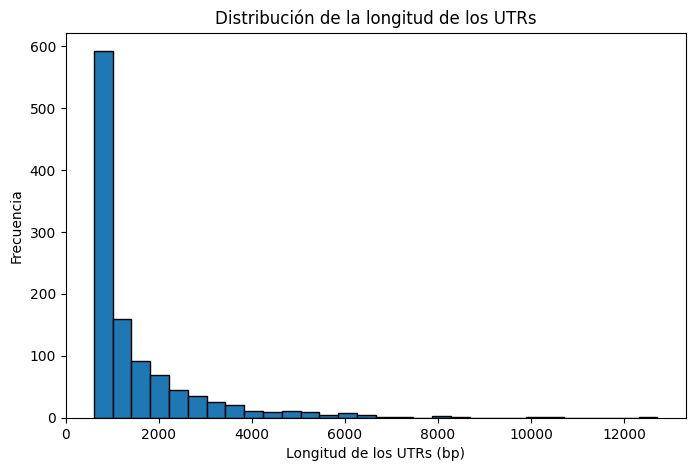

In [ ]:
import matplotlib.pyplot as plt

# Calculate the length of each UTR
df_utr["length"] = df_utr["end"] - df_utr["start"]

# Plot a length histogram
plt.figure(figsize=(8, 5))
plt.hist(df_utr["length"], bins=30, edgecolor='black')
plt.xlabel("Comprimento UTR (bp)")
plt.ylabel("Frequência")
plt.title("Distribuição do Comprimento UTR")
plt.show()

In [ ]:
# Run merge_pa
!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape merge_pa --output_dir /content/scape/examples/toy-example/ \
--utr_merge True"

In [ ]:
# Check if "prepare_input" worked
# Expect ".pk1" files

import os

# List files
os.listdir("/content/scape/examples/toy-example/pkl_input/")

In [ ]:
# Displaying parameters by "infer_pa" (res.utr.pkl)
!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
python -c 'import pickle; f=open(\"/content/scape/examples/toy-example/res.utr.pkl\", \"rb\"); \
print(pickle.load(f))'"

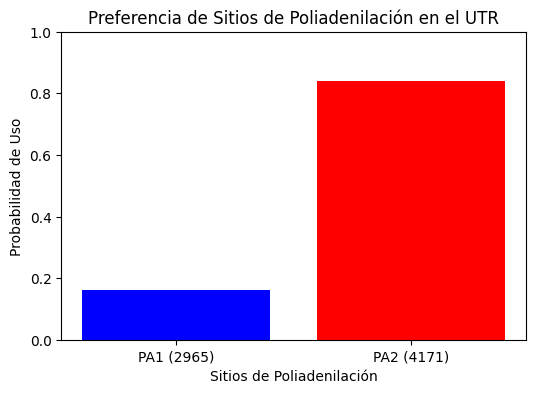

In [ ]:
import matplotlib.pyplot as plt

# PA Site Data
pa_sites = ["PA1 (2965)", "PA2 (4171)"]
usage_probs = [0.16, 0.84]

# Create Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(pa_sites, usage_probs, color=['blue', 'red'])
plt.xlabel("Sítios de Poliadenilação")
plt.ylabel("Probabilidade de Uso")
plt.title("Preferência do Sítio de Poliadenilação na UTR")
plt.ylim(0, 1)

# Show plot
plt.show()

In [ ]:
# merge_pa
# review data
with open("/content/scape/examples/toy-example/res.gene.pkl", "rb") as f:
    try:
        merged_pa = pickle.load(f)
        print(merged_pa)
    except EOFError:
        print("O arquivo res.gene.pkl está vazio.")

In [ ]:
# cal_exp_pa_len
df_exp_len = pd.read_csv("/content/scape/examples/toy-example/cluster_wrt_CB.gene.pa.len.csv")

# Show first lines
df_exp_len.head()

,gene_id,cell_cluster,exp_length,num_pa
0,ENSG00000099194:1,cell1,8.555119,2


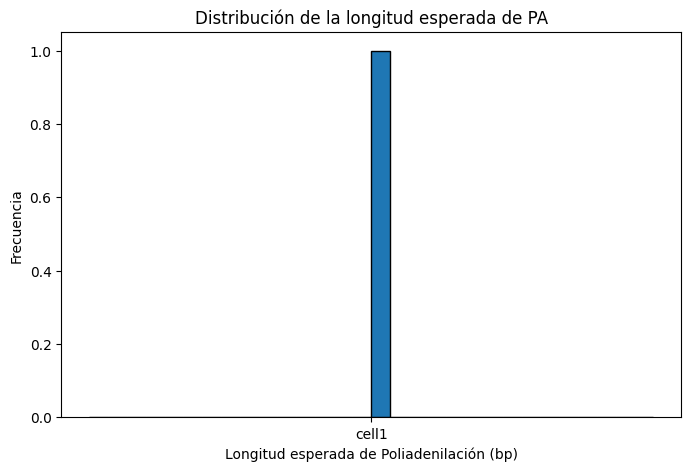

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df_exp_len.iloc[:, 1], bins=30, edgecolor='black')
plt.xlabel("Expected Polyadenylation Length (bp)")
plt.ylabel("Freq")
plt.title("Distribution of Expected Polyadenylation Length")
plt.show()

In [ ]:
#ex_pa_cnt_mat

df_counts = pd.read_csv("/content/scape/examples/toy-example/res.utr.cnt.tsv.gz", sep="\t")

# Show fisrt lines
df_counts.head()

,pa_info,C1_AAACCTGAGACTCGGA-1,C1_AAACCTGAGAGCCTAG-1,C1_AAACCTGAGCCCGAAA-1,C1_AAACCTGAGTACGCGA-1,C1_AAACCTGAGTGGCACA-1,C1_AAACCTGCAAAGCGGT-1,C1_AAACCTGCACTTGGAT-1,C1_AAACCTGCATGGGACA-1,C1_AAACCTGGTGTCCTCT-1,...,S3_TTTGTCAAGTGGAGTC-1,S3_TTTGTCAAGTTCGATC-1,S3_TTTGTCACAGTTAACC-1,S3_TTTGTCACATGTAGTC-1,S3_TTTGTCACATTGGTAC-1,S3_TTTGTCAGTCATGCCG-1,S3_TTTGTCAGTCTTTCAT-1,S3_TTTGTCATCCCTAACC-1,S3_TTTGTCATCGATCCCT-1,S3_TTTGTCATCTCCGGTT-1
0,10:100363599:45.0:+:1:ENSG00000099194:1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,10:100364805:50.0:+:2:ENSG00000099194:1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


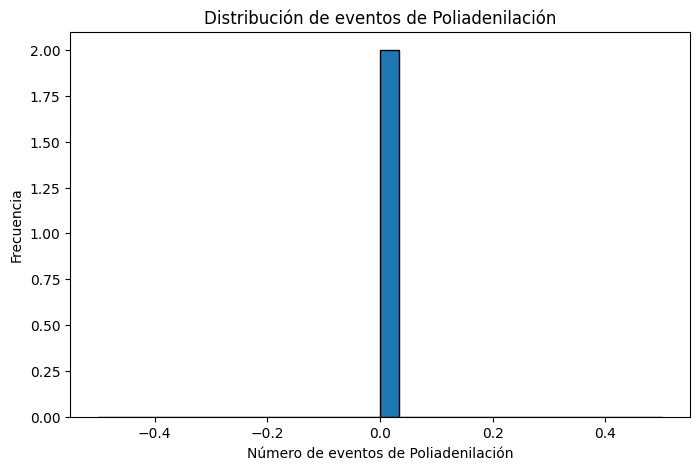

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df_counts.iloc[:, 1], bins=30, edgecolor='black')
plt.xlabel("Number of Polyadenylation Events")
plt.ylabel("Frequency")
plt.title("Distribution of Polyadenylation Events")
plt.show()